In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Nice, clearer plots
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

BASE = Path("..")  # if your notebook lives in notebooks/
DATA_RAW = BASE / "data" / "raw"
DATA_PROCESSED = BASE / "data" / "processed"
FIGDIR = BASE / "reports" / "figures"
FIGDIR.mkdir(parents=True, exist_ok=True)


In [2]:
# Prefer the cleaned dataset if you saved it earlier; else fall back to a raw file
clean_parquet = list(DATA_PROCESSED.glob("cleaned.parquet"))
clean_csv = list(DATA_PROCESSED.glob("cleaned.csv"))

if clean_parquet:
    df = pd.read_parquet(clean_parquet[0])
elif clean_csv:
    df = pd.read_csv(clean_csv[0], low_memory=False)
else:
    csv = next(DATA_RAW.glob("StormEvents_details-*.csv"), None)
    assert csv is not None, "Put a StormEvents_details-*.csv in data/raw or run your preprocessing first."
    df = pd.read_csv(csv, low_memory=False)

# Standardize column names to lowercase
df.columns = df.columns.str.strip().str.lower()

print(df.shape)
df.head()


(19098, 9)


,event_type,state,month,season,magnitude,magnitude_type,begin_lat,begin_lon,damage_property_num
0,Thunderstorm Wind,GEORGIA,3,MAM,52.0,EG,33.4757,-85.238,1000.0
1,Tornado,MICHIGAN,3,MAM,50.0,Unknown,41.7900,-86.100,100000.0
2,Flash Flood,TENNESSEE,4,MAM,50.0,Unknown,36.0300,-89.330,0.0
3,Thunderstorm Wind,TENNESSEE,4,MAM,52.0,EG,36.1800,-88.160,0.0
4,Flash Flood,TENNESSEE,4,MAM,50.0,Unknown,36.3000,-88.710,0.0


In [3]:
# Basic shape, column types, and a sample
display(df.sample(5, random_state=42))
df.info()


,event_type,state,month,season,magnitude,magnitude_type,begin_lat,begin_lon,damage_property_num
15691,Thunderstorm Wind,ARKANSAS,4,MAM,56.0,EG,35.5232,-93.8637,5000.0
9449,Thunderstorm Wind,TENNESSEE,5,MAM,52.0,EG,36.0200,-83.6400,0.0
11039,Marine Thunderstorm Wind,GULF OF MEXICO,5,MAM,39.0,MG,26.0670,-97.1550,0.0
3425,Tornado,MISSISSIPPI,1,DJF,50.0,Unknown,33.8580,-88.6242,10000.0
12844,Thunderstorm Wind,ALABAMA,5,MAM,52.0,EG,31.5200,-87.9000,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19098 entries, 0 to 19097
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_type           19098 non-null  string 
 1   state                19098 non-null  string 
 2   month                19098 non-null  int32  
 3   season               19098 non-null  string 
 4   magnitude            19098 non-null  float64
 5   magnitude_type       19098 non-null  string 
 6   begin_lat            19098 non-null  float64
 7   begin_lon            19098 non-null  float64
 8   damage_property_num  19098 non-null  float64
dtypes: float64(4), int32(1), string(4)
memory usage: 1.2 MB


,missing_ratio
event_type,0.0
state,0.0
month,0.0
season,0.0
magnitude,0.0
magnitude_type,0.0
begin_lat,0.0
begin_lon,0.0
damage_property_num,0.0


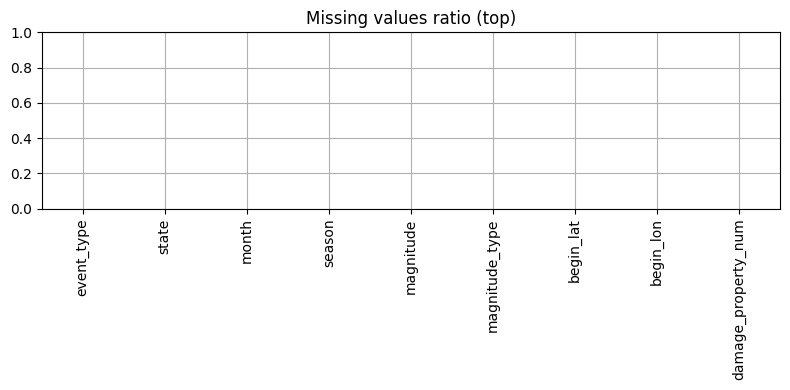

In [4]:
na = df.isna().mean().sort_values(ascending=False)
display(na.to_frame("missing_ratio").head(20))
na.plot(kind="bar", title="Missing values ratio (top)", ylim=(0,1))
plt.tight_layout(); plt.show()


In [5]:
import re

if "damage_property_num" not in df.columns:
    def parse_damage(x):
        if pd.isna(x): return 0.0
        s = str(x).strip().upper()
        if s == "" or s == "0.00K": return 0.0
        m = re.match(r"^([0-9.]+)\s*([KMB])$", s)
        if not m: return np.nan
        val = float(m.group(1))
        mul = {"K":1e3, "M":1e6, "B":1e9}[m.group(2)]
        return val * mul
    assert "damage_property" in df.columns, "Need damage_property to build damage_property_num."
    df["damage_property_num"] = df["damage_property"].apply(parse_damage)

df["damage_property_num"].describe()


count     19098.000000
mean      10920.691172
std       67390.742112
min           0.000000
25%           0.000000
50%           0.000000
75%        1000.000000
max      762875.000000
Name: damage_property_num, dtype: float64

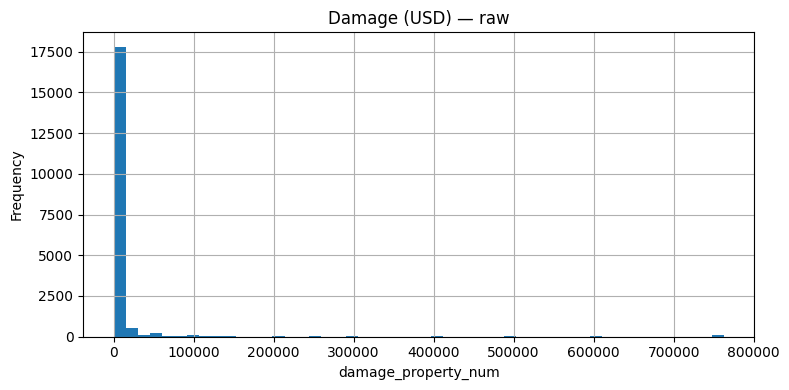

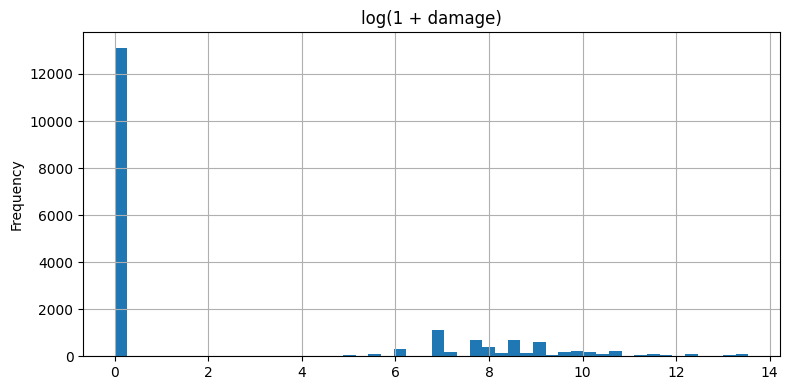

In [6]:
ax = df["damage_property_num"].plot(kind="hist", bins=50, title="Damage (USD) — raw")
plt.xlabel("damage_property_num"); plt.tight_layout(); plt.show()

# Log scale (add 1 to avoid log(0))
np.log1p(df["damage_property_num"]).plot(kind="hist", bins=50, title="log(1 + damage)")
plt.tight_layout(); plt.show()


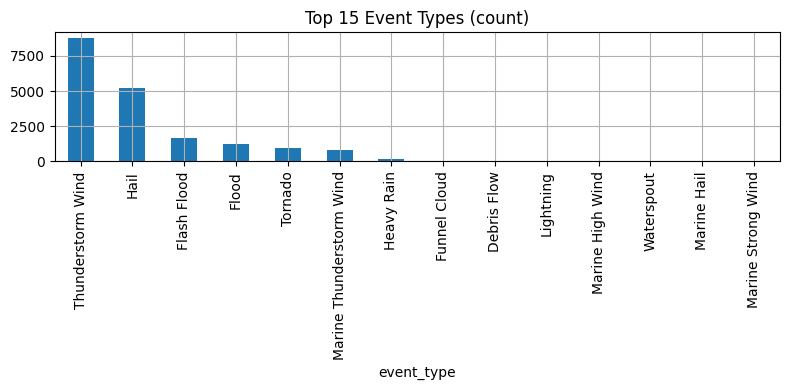

event_type
Thunderstorm Wind           8736
Hail                        5193
Flash Flood                 1676
Flood                       1244
Tornado                      992
Marine Thunderstorm Wind     781
Heavy Rain                   197
Funnel Cloud                  68
Debris Flow                   66
Lightning                     62
Marine High Wind              31
Waterspout                    26
Marine Hail                   20
Marine Strong Wind             6
Name: count, dtype: Int64

In [7]:
if "event_type" in df.columns:
    top = df["event_type"].value_counts().head(15)
    top.plot(kind="bar", title="Top 15 Event Types (count)")
    plt.tight_layout(); plt.show()
    display(top)
else:
    print("Column event_type missing.")


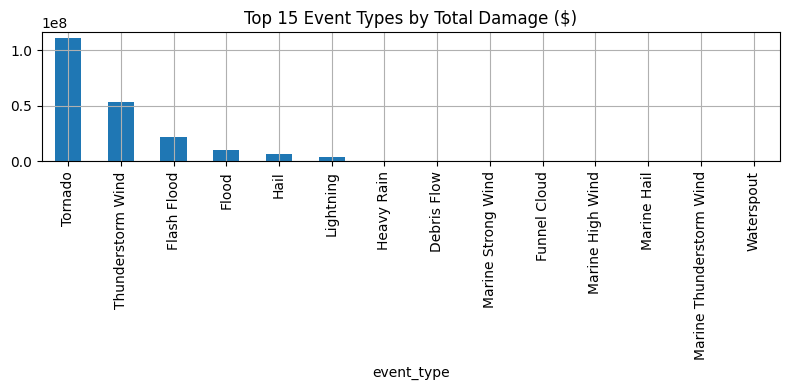

event_type
Tornado                     $110,724,500
Thunderstorm Wind            $53,739,360
Flash Flood                  $21,900,600
Flood                        $10,331,250
Hail                          $6,541,475
Lightning                     $4,446,575
Heavy Rain                      $578,100
Debris Flow                     $297,500
Marine Strong Wind                $4,000
Funnel Cloud                          $0
Marine High Wind                      $0
Marine Hail                           $0
Marine Thunderstorm Wind              $0
Waterspout                            $0
Name: damage_property_num, dtype: object

In [8]:
if "event_type" in df.columns:
    grp = df.groupby("event_type")["damage_property_num"].sum().sort_values(ascending=False).head(15)
    grp.plot(kind="bar", title="Top 15 Event Types by Total Damage ($)")
    plt.tight_layout(); plt.show()
    display(grp.apply(lambda x: f"${x:,.0f}"))


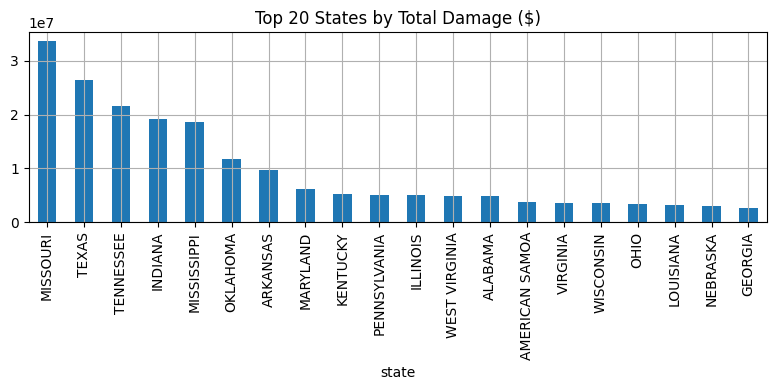

state
MISSOURI          $33,637,375
TEXAS             $26,403,375
TENNESSEE         $21,587,950
INDIANA           $19,168,700
MISSISSIPPI       $18,551,125
OKLAHOMA          $11,739,875
ARKANSAS           $9,770,500
MARYLAND           $6,272,125
KENTUCKY           $5,218,800
PENNSYLVANIA       $4,993,200
ILLINOIS           $4,988,850
WEST VIRGINIA      $4,965,300
ALABAMA            $4,795,950
AMERICAN SAMOA     $3,720,750
VIRGINIA           $3,640,550
WISCONSIN          $3,577,125
OHIO               $3,439,950
LOUISIANA          $3,178,375
NEBRASKA           $3,092,875
GEORGIA            $2,608,100
Name: damage_property_num, dtype: object

In [9]:
if "state" in df.columns:
    by_state = df.groupby("state")["damage_property_num"].sum().sort_values(ascending=False).head(20)
    by_state.plot(kind="bar", title="Top 20 States by Total Damage ($)")
    plt.tight_layout(); plt.show()
    display(by_state.apply(lambda x: f"${x:,.0f}"))


In [12]:
# Attempt to construct a datetime if needed
if "begin_date_time" in df.columns and not np.issubdtype(df["begin_date_time"].dtype, np.datetime64):
    # try strict first, then flexible
    dt = pd.to_datetime(df["begin_date_time"], format="%m/%d/%Y %H:%M:%S", errors="coerce")
    if dt.notna().sum() == 0:
        dt = pd.to_datetime(df["begin_date_time"], errors="coerce")
    df["begin_date_time"] = dt

if "begin_date_time" in df.columns:
    df["year"] = df["begin_date_time"].dt.year
    df["month"] = df["begin_date_time"].dt.month

if "year" in df.columns:
    yearly = df.groupby("year")["damage_property_num"].sum()
    yearly.plot(title="Total Damage by Year")
    plt.tight_layout(); plt.show()
    display(yearly.apply(lambda x: f"${x:,.0f}"))

if "month" in df.columns and "year" in df.columns:
    ym = df.groupby(["year","month"])["damage_property_num"].sum().reset_index()
    # Simple line plot by year-month index
    ym["ym"] = pd.to_datetime(ym["year"].astype(str) + "-" + ym["month"].astype(str) + "-01")
    ym = ym.sort_values("ym")
    plt.plot(ym["ym"], ym["damage_property_num"])
    plt.title("Total Damage over Time (monthly)")
    plt.xlabel("Date"); plt.ylabel("Damage ($)")
    plt.tight_layout(); plt.show()


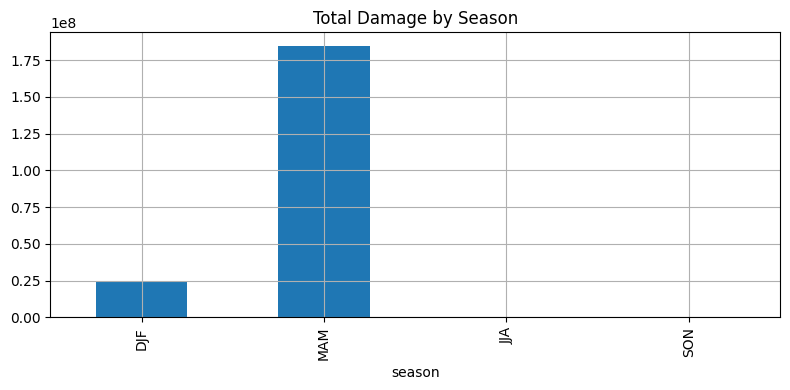

season
DJF     $23,838,560
MAM    $184,724,800
JJA            $nan
SON            $nan
Name: damage_property_num, dtype: object

In [13]:
# Build season if not present
if "season" not in df.columns and "month" in df.columns:
    season_map = {12:"DJF",1:"DJF",2:"DJF", 3:"MAM",4:"MAM",5:"MAM", 6:"JJA",7:"JJA",8:"JJA", 9:"SON",10:"SON",11:"SON"}
    df["season"] = df["month"].map(season_map)

if "season" in df.columns:
    by_season = df.groupby("season")["damage_property_num"].sum().reindex(["DJF","MAM","JJA","SON"])
    by_season.plot(kind="bar", title="Total Damage by Season")
    plt.tight_layout(); plt.show()
    display(by_season.apply(lambda x: f"${x:,.0f}"))


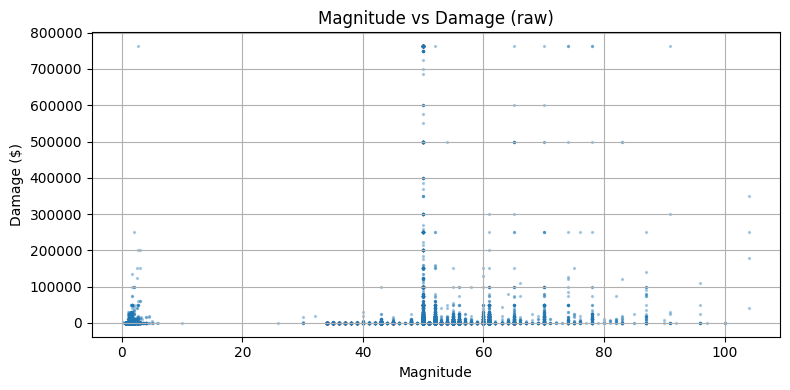

C:\Users\sanjana\AppData\Local\Temp\ipykernel_17412\2126766414.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mag_trend = df.groupby(bins)["damage_property_num"].median()


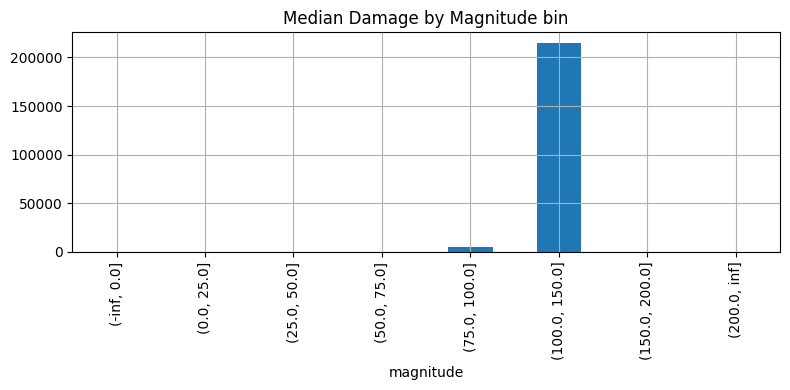

In [14]:
if "magnitude" in df.columns:
    ax = plt.scatter(df["magnitude"], df["damage_property_num"], s=2, alpha=0.3)
    plt.xlabel("Magnitude"); plt.ylabel("Damage ($)"); plt.title("Magnitude vs Damage (raw)")
    plt.tight_layout(); plt.show()

    # Bin magnitude to see trend
    bins = pd.cut(df["magnitude"], bins=[-np.inf,0,25,50,75,100,150,200,np.inf])
    mag_trend = df.groupby(bins)["damage_property_num"].median()
    mag_trend.plot(kind="bar", title="Median Damage by Magnitude bin")
    plt.tight_layout(); plt.show()

,corr_with_damage
damage_property_num,1.000000
magnitude,0.095572
begin_lon,-0.029813
begin_lat,-0.036307
month,-0.049363


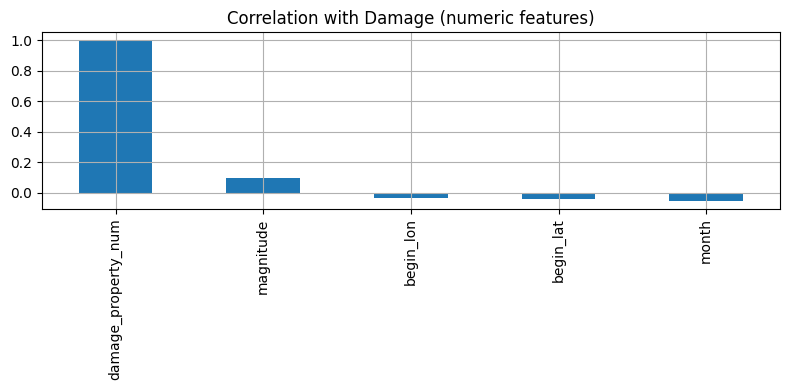

In [15]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "damage_property_num" in num_cols:
    corr = df[num_cols].corr(numeric_only=True)["damage_property_num"].sort_values(ascending=False)
    display(corr.to_frame("corr_with_damage").head(15))
    corr.plot(kind="bar", title="Correlation with Damage (numeric features)")
    plt.tight_layout(); plt.show()
else:
    print("No numeric target available.")


In [16]:
# Damage by event type and season
if "event_type" in df.columns and "season" in df.columns:
    p = pd.pivot_table(df, values="damage_property_num", index="event_type", columns="season", aggfunc="sum", fill_value=0)
    display(p.sort_values(("DJF"), ascending=False).head(10))

# Damage by state and event type (top 10 states)
if "state" in df.columns and "event_type" in df.columns:
    top_states = df.groupby("state")["damage_property_num"].sum().sort_values(ascending=False).head(10).index
    p2 = pd.pivot_table(df[df["state"].isin(top_states)],
                        values="damage_property_num", index="state", columns="event_type", aggfunc="sum", fill_value=0)
    display(p2.iloc[:, :10])  # show first 10 event types for width


season,DJF,MAM
event_type,,
Flash Flood,8833500.0,1.306710e+07
Tornado,5785625.0,1.049389e+08
Flood,5572925.0,4.758325e+06
Thunderstorm Wind,2731410.0,5.100795e+07
Heavy Rain,537100.0,4.100000e+04
Lightning,305000.0,4.141575e+06
Hail,35000.0,6.506475e+06
Debris Flow,34000.0,2.635000e+05
Marine Strong Wind,4000.0,0.000000e+00


event_type,Debris Flow,Flash Flood,Flood,Funnel Cloud,Hail,Heavy Rain,Lightning,Thunderstorm Wind,Tornado
state,,,,,,,,,
ARKANSAS,0.0,41000.0,0.0,0.0,583000.0,0.0,0.0,777000.0,8369500.0
INDIANA,0.0,3485000.0,5000.0,0.0,62500.0,0.0,137500.0,4544700.0,10934000.0
KENTUCKY,10000.0,337000.0,3647675.0,0.0,772875.0,0.0,0.0,176250.0,275000.0
MARYLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4949250.0,1322875.0
MISSISSIPPI,0.0,794000.0,8000.0,0.0,278000.0,0.0,210000.0,5231375.0,12029750.0
MISSOURI,0.0,1726000.0,250000.0,0.0,1230000.0,50000.0,0.0,3921375.0,26460000.0
OKLAHOMA,0.0,1230000.0,150000.0,0.0,1774000.0,0.0,0.0,1726000.0,6859875.0
PENNSYLVANIA,0.0,206700.0,0.0,0.0,0.0,0.0,30000.0,3881500.0,875000.0
TENNESSEE,0.0,2496625.0,3125750.0,0.0,85000.0,0.0,107000.0,4094200.0,11679375.0


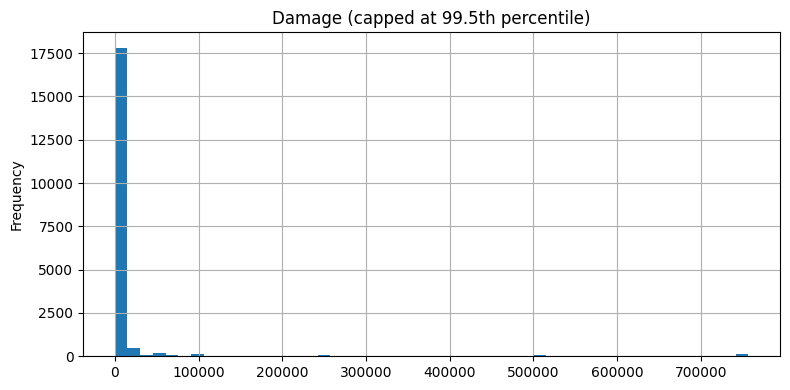

In [17]:
# Cap only for plotting (does not change your training data unless you assign back)
cap = df["damage_property_num"].quantile(0.995)
df_plot = df.copy()
df_plot["damage_capped"] = np.where(df_plot["damage_property_num"] > cap, cap, df_plot["damage_property_num"])

df_plot["damage_capped"].plot(kind="hist", bins=50, title="Damage (capped at 99.5th percentile)")
plt.tight_layout(); plt.show()


In [18]:
# Re-run a couple of high-value figures and save them
if "event_type" in df.columns:
    ax = df["event_type"].value_counts().head(15).plot(kind="bar", title="Top 15 Event Types (count)")
    plt.tight_layout(); plt.savefig(FIGDIR / "top_event_types_count.png"); plt.close()

if "state" in df.columns:
    ax = df.groupby("state")["damage_property_num"].sum().sort_values(ascending=False).head(20).plot(kind="bar", title="Top 20 States by Damage")
    plt.tight_layout(); plt.savefig(FIGDIR / "top_states_damage.png"); plt.close()

if "year" in df.columns:
    ax = df.groupby("year")["damage_property_num"].sum().plot(title="Total Damage by Year")
    plt.tight_layout(); plt.savefig(FIGDIR / "damage_by_year.png"); plt.close()

print("Saved figures to", FIGDIR)


Saved figures to ..\reports\figures


In [19]:
summary = {
    "rows": int(df.shape[0]),
    "cols": int(df.shape[1]),
    "has_event_type": "event_type" in df.columns,
    "has_state": "state" in df.columns,
    "date_parsed_rows": int(df["begin_date_time"].notna().sum()) if "begin_date_time" in df.columns else 0,
    "zero_damage_ratio": float((df["damage_property_num"]==0).mean()) if "damage_property_num" in df.columns else None,
}
summary


{'rows': 19098,
 'cols': 9,
 'has_event_type': True,
 'has_state': True,
 'date_parsed_rows': 0,
 'zero_damage_ratio': 0.6866163996229971}